In [ ]:
# Project setup - paths relative to repository root
import sys
from pathlib import Path

# Set up project paths
PROJECT_ROOT = Path().absolute().parent
DATA_DIR = PROJECT_ROOT / 'data'
OUTPUT_DIR = PROJECT_ROOT / 'outputs'
OUTPUT_DIR.mkdir(exist_ok=True)

# Add src to path for imports
sys.path.insert(0, str(PROJECT_ROOT / 'src'))

import os, glob
from utils import (prepare_sequences, 
                   add_temporal_features, 
                   cv_leave_one_out_split,
                   create_feature_combinations,
                   get_temporal_feature_names,
                   create_optuna_objective,
                   get_date_stats,
                   custom_error_matrix,
                   custom_f1_score,
                   plot_scatter_doys,
                   calculate_mape_and_offset
                   )
from management import remove_close_mowing

import pandas as pd
import geopandas as gpd
from tqdm import tqdm

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import f1_score, roc_auc_score, mean_absolute_error, confusion_matrix
import optuna

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [ ]:
# Load Model
import joblib
model = joblib.load(OUTPUT_DIR / "RF_opt_vi_text_035.joblib")

In [3]:
# Define columns to load
input_id_cols = ['PLOTID', 'Date']


s2_cols = [
    'blue', 'green', 'red', 'nir', 're1', 're2', 're3',
    'swir1', 'swir2', 'ndvi', 'spatial_max',
    'ndvi_texture_sd_3', 'ndvi_texture_sd_5'
] + input_id_cols
input_variables = [
    'blue', 'green', 'red', 'nir', 're1', 're2', 're3',
    'swir1', 'swir2', 'ndvi', 'spatial_max',
    'ndvi_texture_sd_3', 'ndvi_texture_sd_5']

model_vars = [
    'blue_diff_1', 'green_diff_1', 'red_diff_1', 'nir_diff_1', 're1_diff_1',
    're2_diff_1', 're3_diff_1', 'swir1_diff_1', 'swir2_diff_1', 'ndvi_diff_1', 'doy_diff_1', 'bsi_diff_1', 
    'blue', 'green', 'red', 'nir', 're1', 're2', 're3', 'swir1', 'swir2', 'ndvi',  'bsi', 'diff_max', 
    'ndvi_texture_sd_5', 'ndvi_texture_sd_5_diff_1', 'ndvi_texture_sd_3', 'ndvi_texture_sd_3_diff_1'
       ]

id_cols = ['PLOTID', 'Date', 'year', 'mowing', 'id']
plotID_col = 'PLOTID'

# Slovakia Spatial Transfer

In [ ]:
# Slovakia test data paths
SK_points = gpd.read_file(DATA_DIR / 'test' / 'SK_long.gpkg')
SK_points['year'] = SK_points['date'].dt.year
SK_points['PLOTID'] = SK_points['plotID']
sk_ts_S2_path = str(DATA_DIR / 'test' / 'SK_poly' / '*.csv')

In [7]:
sk_df = prepare_sequences(
    use_s1=False,
    points=SK_points,
    s1_paths=None,
    s2_paths=glob.glob(sk_ts_S2_path),
    coh_paths=None,
    s1_cols=None,
    s2_cols=s2_cols,
    coh_cols=None,
)
sk_df['diff_max'] = sk_df['ndvi'] - sk_df['spatial_max']
sk_df['bsi'] = (
    (sk_df["swir1"] + sk_df["red"]) - (sk_df["nir"] - sk_df["blue"])
    ) / (
    (sk_df["swir1"] + sk_df["red"]) + (sk_df["nir"] + sk_df["blue"])
    )

sk_df['doy'] = sk_df['Date'].dt.day_of_year
sk_df = add_temporal_features(
    df=sk_df,
    columns=input_variables+['doy', 'bsi'],
    group_cols=['PLOTID', 'year'],
    date_col='Date',
    past_steps=1
)
    
temporal_features = get_temporal_feature_names(
    base_features=input_variables+['doy', 'bsi'],
    past_steps=1,
)
sk_df = sk_df[model_vars+id_cols]
sk_df = sk_df.dropna(subset=model_vars)

sk_X = sk_df[model_vars]
sk_y = sk_df['mowing']

sk_all_results = []
sk_y_pred = model.predict_proba(sk_X)#[:, 1] if hasattr(model, "predict_proba") else model.predict(sk_X)
sk_y_pred_bin = (sk_y_pred[:, 1]  >= 0.35).astype(int)
sk_df['pred_mowing'] = sk_y_pred_bin
if plotID_col not in sk_df.columns:
    sk_df[plotID_col] = sk_df['PLOTID']  # fallback: use PLOTID

if 'doy' not in sk_df.columns:
    sk_df['doy'] = sk_df['Date'].dt.day_of_year

# --- Remove Close Mowing (15 days)
sk_df = sk_df.groupby(['PLOTID', 'year'], group_keys=False).apply(remove_close_mowing, 'pred_mowing')

# --- Error matrix and validation metrics ---
sk_metrics = custom_error_matrix(
    sk_df,
    sk_df['pred_mowing'],
    'mowing',
    window_after = 12,
    window_before = 12
)

sk_comparision, sk_date_metrics = get_date_stats(sk_df, SK_points, sk_df['pred_mowing'], 'PLOTID')

sk_res = (
    sk_df.groupby(['PLOTID', 'year'])
    .agg(preds=('pred_mowing', 'sum'), ref=('mowing', 'sum'))
    .reset_index()[['preds', 'ref']]
)

mape = calculate_mape_and_offset(sk_res['preds'], sk_res['ref'])
mae_nMowing = mean_absolute_error(sk_res['preds'], sk_res['ref'])
mean_error_nMowing = np.mean(sk_res['ref'] - sk_res['preds'])
auc = roc_auc_score(sk_df['mowing'], sk_df['pred_mowing'])

# --- Save results ---
sk_all_results.append({
    'f1': sk_metrics['F1'],
    'auc': auc,
    'precision': sk_metrics['Precision'],
    'recall': sk_metrics['Recall'],
    'mae_nMowing': mae_nMowing,
    'mean_error_nMowing': mean_error_nMowing,
    'mape': mape[0],
    'mape_offset': mape[1],
    'tp': sk_metrics['TP'],
    'fp': sk_metrics['FP'],
    'fn': sk_metrics['FN'],
    'tn': sk_metrics['TN'],
    'rmse': sk_date_metrics['RMSE'],
    'mae': sk_date_metrics['MAE'],
    'r2': sk_date_metrics['R²'],
    'max_error': sk_date_metrics['Max Error'],
    'mead_deviance': sk_date_metrics['Mean Deviance'],
})

# Switzerland Spatial Transfer

In [ ]:
# Switzerland test data paths
CH_points = gpd.read_file(DATA_DIR / 'test' / 'CH_long.gpkg')
CH_points['year'] = CH_points['date'].dt.year
CH_points['PLOTID'] = CH_points['plotID']
ch_ts_S2_path = str(DATA_DIR / 'test' / 'CH_poly' / '*.csv')

In [9]:
ch_df = prepare_sequences(
    use_s1=False,
    points=CH_points,
    s1_paths=None,
    s2_paths=glob.glob(ch_ts_S2_path),
    coh_paths=None,
    s1_cols=None,
    s2_cols=s2_cols,
    coh_cols=None,
)
ch_df['diff_max'] = ch_df['ndvi'] - ch_df['spatial_max']
ch_df['bsi'] = (
    (ch_df["swir1"] + ch_df["red"]) - (ch_df["nir"] - ch_df["blue"])
    ) / (
    (ch_df["swir1"] + ch_df["red"]) + (ch_df["nir"] + ch_df["blue"])
    )

ch_df['doy'] = ch_df['Date'].dt.day_of_year
ch_df = add_temporal_features(
    df=ch_df,
    columns=input_variables+['doy', 'bsi'],
    group_cols=['PLOTID', 'year'],
    date_col='Date',
    past_steps=1
)
    
temporal_features = get_temporal_feature_names(
    base_features=input_variables+['doy', 'bsi'],
    past_steps=1,
)
ch_df = ch_df[model_vars+id_cols]
ch_df = ch_df.dropna(subset=model_vars)

ch_X = ch_df[model_vars]
ch_y = ch_df['mowing']

ch_all_results = []
ch_y_pred = model.predict_proba(ch_X) #if hasattr(model, "predict_proba") else model.predict(ch_X)
ch_y_pred_bin = (ch_y_pred[:, 1] >= 0.35).astype(int)
ch_df['pred_mowing'] = ch_y_pred_bin
if plotID_col not in ch_df.columns:
    ch_df[plotID_col] = ch_df['PLOTID']  # fallback: use PLOTID

if 'doy' not in ch_df.columns:
    ch_df['doy'] = ch_df['Date'].dt.day_of_year

# --- Remove Close Mowing (15 days)
ch_df = ch_df.groupby(['PLOTID', 'year'], group_keys=False).apply(remove_close_mowing, 'pred_mowing')

# --- Error matrix and validation metrics ---
ch_metrics = custom_error_matrix(
    ch_df,
    ch_df['pred_mowing'],
    'mowing',
    window_after = 12
)

ch_comparision, ch_date_metrics = get_date_stats(ch_df, CH_points, ch_df['pred_mowing'], 'PLOTID')

ch_res = (
    ch_df.groupby(['PLOTID', 'year'])
    .agg(preds=('pred_mowing', 'sum'), ref=('mowing', 'sum'))
    .reset_index()[['preds', 'ref']]
)

mape = calculate_mape_and_offset(ch_res['preds'], ch_res['ref'])
mae_nMowing = mean_absolute_error(ch_res['preds'], ch_res['ref'])
mean_error_nMowing = np.mean(ch_res['ref'] - ch_res['preds'])
auc = roc_auc_score(ch_df['mowing'], ch_df['pred_mowing'])

# --- Save results ---
ch_all_results.append({
    'f1': ch_metrics['F1'],
    'auc': auc,
    'precision': ch_metrics['Precision'],
    'recall': ch_metrics['Recall'],
    'mae_nMowing': mae_nMowing,
    'mean_error_nMowing': mean_error_nMowing,
    'mape': mape[0],
    'mape_offset': mape[1],
    'tp': ch_metrics['TP'],
    'fp': ch_metrics['FP'],
    'fn': ch_metrics['FN'],
    'tn': ch_metrics['TN'],
    'rmse': ch_date_metrics['RMSE'],
    'mae': ch_date_metrics['MAE'],
    'r2': ch_date_metrics['R²'],
    'max_error': ch_date_metrics['Max Error'],
    'mead_deviance': ch_date_metrics['Mean Deviance'],
})

# Visualisation

## Frequency

In [19]:
# Re-bin classes: 0, 1, 2, 3+
def rebin(x):
    return np.where(x >= 3, "3+", x.astype(int).astype(str))

def summarize_errors_by_ref_bin(
    res: pd.DataFrame,
    region: str,
    ref_col: str = "ref",
    pred_col: str = "preds",
    rebin_func=None,
    strata_order=("0", "1", "2", "3+"),
) -> pd.DataFrame:
    """
    Summarize prediction errors per reference stratum.

    Parameters
    ----------
    res : pd.DataFrame
        Results dataframe containing reference and prediction columns.
    region : str
        Region name to attach to the summary output.
    ref_col : str, default "ref"
        Column name with reference counts.
    pred_col : str, default "preds"
        Column name with predicted counts.
    rebin_func : callable
        Function used to bin reference and prediction values
        (e.g. rebin(x) -> {"0","1","2","3+"}).
    strata_order : tuple of str
        Fixed ordering of reference strata.

    Returns
    -------
    pd.DataFrame
        Summary table with columns:
        [ref_bin, n, mean_error, mae, rmse, region]
    """

    if rebin_func is None:
        raise ValueError("A rebin_func must be provided.")

    df = res.copy()

    # --------------------------------------------------
    # Binning
    # --------------------------------------------------
    df["ref_bin"]  = rebin_func(df[ref_col])
    df["pred_bin"] = rebin_func(df[pred_col])

    # --------------------------------------------------
    # Numeric capped versions for error computation
    # --------------------------------------------------
    df["ref_num"] = np.where(df[ref_col]  >= 3, 3, df[ref_col])
    df["pred_num"] = np.where(df[pred_col] >= 3, 3, df[pred_col])

    # --------------------------------------------------
    # Errors
    # --------------------------------------------------
    df["err"] = df["pred_num"] - df["ref_num"]
    df["ae"]  = df["err"].abs()
    df["se"]  = df["err"] ** 2

    # --------------------------------------------------
    # Aggregate per reference stratum
    # --------------------------------------------------
    summary = (
        df.groupby("ref_bin", observed=True)
          .agg(
              n=("err", "size"),
              mean_error=("err", "mean"),
              mae=("ae", "mean"),
              rmse=("se", lambda s: np.sqrt(s.mean())),
          )
          .reset_index()
    )

    # --------------------------------------------------
    # Enforce stratum order
    # --------------------------------------------------
    summary["ref_bin"] = pd.Categorical(
        summary["ref_bin"],
        categories=strata_order,
        ordered=True
    )
    summary = summary.sort_values("ref_bin")

    # --------------------------------------------------
    # Add region label
    # --------------------------------------------------
    summary["region"] = region

    return summary

In [20]:
df1 = summarize_errors_by_ref_bin(sk_res, region='Slovakia', rebin_func=rebin)
df2 = summarize_errors_by_ref_bin(ch_res, region='Switzerland', rebin_func=rebin)
df = pd.concat([df1, df2])

In [ ]:
# Set up the plot style
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 10

cm_to_in = 1 / 2.54
fig_w, fig_h = 15.9 * cm_to_in, 7 * cm_to_in

fig, axes = plt.subplots(1, 3, figsize=(fig_w, fig_h))  # A4 width

regions = df['region'].unique()
colors = {'Switzerland': '#8da0cb', 'Slovakia': '#fc8d62'}  # ColorBrewer Set2

x = np.arange(len(df['ref_bin'].unique()))
width = 0.35

# ====================================================
# Plot 1: Mean Error by class
# ====================================================
ax = axes[0]
for i, region in enumerate(regions):
    region_data = df[df['region'] == region]
    offset = width * (i - 0.5)
    ax.bar(
        x + offset,
        region_data['mean_error'],
        width,
        label=region,
        color=colors[region],
        alpha=0.8
    )

ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.set_xlabel('Reference mowing count')
ax.set_ylabel('ME')
ax.set_xticks(x)
ax.set_xticklabels(df['ref_bin'].unique())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3, linestyle=':')

# ====================================================
# Plot 2: MAE by class
# ====================================================
ax = axes[1]
for i, region in enumerate(regions):
    region_data = df[df['region'] == region]
    offset = width * (i - 0.5)
    ax.bar(
        x + offset,
        region_data['mae'],
        width,
        label=region,
        color=colors[region],
        alpha=0.8
    )

ax.set_xlabel('Reference mowing count')
ax.set_ylabel('MAE')
ax.set_xticks(x)
ax.set_xticklabels(df['ref_bin'].unique())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3, linestyle=':')

# ====================================================
# Plot 3: RMSE by class
# ====================================================
ax = axes[2]
for i, region in enumerate(regions):
    region_data = df[df['region'] == region]
    offset = width * (i - 0.5)
    ax.bar(
        x + offset,
        region_data['rmse'],
        width,
        label=region,
        color=colors[region],
        alpha=0.8
    )

ax.set_xlabel('Reference mowing count')
ax.set_ylabel('RMSE')
ax.set_xticks(x)
ax.set_xticklabels(df['ref_bin'].unique())
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.3, linestyle=':')

# ====================================================
# Global legend (top, 2 columns)
# ====================================================
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='upper center',
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, 1.05),
    handlelength=1.4,
    columnspacing=1.8
)

# Remove per-axis legends
for ax in axes:
    leg = ax.get_legend()
    if leg is not None:
        leg.remove()

# Leave room for legend
plt.tight_layout(rect=[0, 0, 1, 0.92])
# plt.savefig(OUTPUT_DIR / 'spatial_transfer_frequency.png', dpi=300, bbox_inches="tight")
plt.show()

## Timing

In [37]:
import matplotlib as mpl

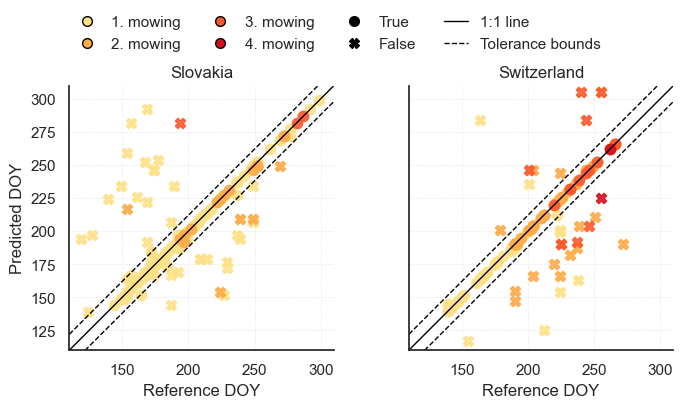

In [48]:
# --- Publication settings (A4 landscape width, Arial) ---
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 10

def plot_scatter_doys_two_regions(
    df_left: pd.DataFrame,
    df_point_left: pd.DataFrame,
    pred_left: np.ndarray,
    left_title: str,
    df_right: pd.DataFrame,
    df_point_right: pd.DataFrame,
    pred_right: np.ndarray,
    right_title: str,
    plotID_col: str = "PLOTID",
    tolerance_before: int = 12,
    tolerance_after: int = 12,
    xlim: tuple[int, int] = (110, 310),
    ylim: tuple[int, int] = (110, 310),
) -> None:
    """
    Two-panel (2 columns) publication-ready scatter: Reference DOY (x) vs Predicted DOY (y)
    for two regions side-by-side. Panels are square and fit together on A4 width.

    - Color by mowing_event (1st, 2nd, ...).
    - Marker shape by correctness: 'o' for TP (within tolerance), 'X' for FP.
    - One shared legend above the figure with two columns.
    """

    def _prepare_comparison(df: pd.DataFrame, df_point: pd.DataFrame, pred: np.ndarray) -> pd.DataFrame:
        # Point preprocessing (kept for parity with your original; not used further)
        _ = df_point[[plotID_col, "year", "date", "type"]].copy()
        _ = _[_["type"] == "k"]
        _["doy"] = _["date"].dt.dayofyear
        _["year"] = _["date"].dt.year.astype(int)
        _["mowing_event"] = _.groupby([plotID_col, "year"]).cumcount()

        # Predictions
        d = df.copy()
        d["pred"] = pred
        pred_mows = (
            d[d["pred"] == 1][[plotID_col, "year", "doy", "pred"]]
            .drop_duplicates(subset=[plotID_col, "year", "doy"])
        )
        pred_mows["mowing_event"] = pred_mows.groupby([plotID_col, "year"]).cumcount()

        # Actuals
        actual_mows = (
            d[d["mowing"] == 1][[plotID_col, "year", "doy", "mowing"]]
            .drop_duplicates(subset=[plotID_col, "year", "doy"])
        )
        actual_mows["mowing_event"] = actual_mows.groupby([plotID_col, "year"]).cumcount()

        # Pair by (plot, year, event order)
        comparison = pred_mows.merge(
            actual_mows,
            how="outer",
            on=[plotID_col, "year", "mowing_event"],
            suffixes=("_x", "_y"),
        ).dropna(subset=["doy_x", "doy_y"]).copy()

        comparison["mowing_event"] = comparison["mowing_event"].astype(int)

        # TP/FP by tolerance window
        within = (
            (comparison["doy_y"] >= (comparison["doy_x"] - tolerance_before)) &
            (comparison["doy_y"] <= (comparison["doy_x"] + tolerance_after))
        )
        comparison["prediction"] = np.where(within, "TP", "FP")

        return comparison.sort_values("mowing_event").reset_index(drop=True)

    # Prepare both regions
    left = _prepare_comparison(df_left, df_point_left, pred_left)
    right = _prepare_comparison(df_right, df_point_right, pred_right)

    # Unified color mapping across both panels (so "1st mowing" matches color in both)
    unique_events = sorted(set(left["mowing_event"].unique()).union(set(right["mowing_event"].unique())))
    palette = sns.color_palette("YlOrRd", n_colors=len(unique_events))
    color_map = {ev: palette[i] for i, ev in enumerate(unique_events)}

    # --- A4 width in inches (landscape) and square panels ---
    # A4 landscape width = 11.69 in. Make height to accommodate legend + squares.
    fig_w = 7.8
    fig_h = 7.8 / 2 # enough for two square-ish axes plus top legend

    sns.set_theme(style="white")
    fig, axes = plt.subplots(1, 2, figsize=(fig_w, fig_h), sharex=True, sharey=True)

    for ax, data, title in [
        (axes[0], left, left_title),
        (axes[1], right, right_title),
    ]:
        # Reference lines (fixed to xlim/ylim for consistent appearance)
        doy_limits = [min(xlim[0], ylim[0]), max(xlim[1], ylim[1])]
        ax.plot(doy_limits, doy_limits, color="black", linestyle="-", linewidth=1, label="1:1 line")
        ax.plot(
            doy_limits,
            [x + tolerance_before for x in doy_limits],
            color="black",
            linestyle="--",
            linewidth=1,
            label=f"+{tolerance_before} days",
        )
        ax.plot(
            doy_limits,
            [x - tolerance_after for x in doy_limits],
            color="black",
            linestyle="--",
            linewidth=1,
            label=f"-{tolerance_after} days",
        )

        # Scatter (x=reference, y=predicted)
        for _, row in data.iterrows():
            ax.scatter(
                row["doy_y"],
                row["doy_x"],
                color=color_map[row["mowing_event"]],
                s=55,
                marker="o" if row["prediction"] == "TP" else "X",
                linewidth=1.0,
                edgecolor=None,
                alpha=0.9,
            )

        ax.set_title(title)
        ax.set_xlabel("Reference DOY")
        ax.set_xlim(*xlim)
        ax.set_ylim(*ylim)

        # Square panels
        ax.set_aspect("equal", adjustable="box")

        # Publication-style grid
        ax.grid(axis="both", linestyle=":", alpha=0.6, linewidth=0.6)

        sns.despine(ax=ax)

    axes[0].set_ylabel("Predicted DOY")
    axes[1].set_ylabel("")

    # ---- Single legend above the figure (two columns) ----
    # Build legend handles: event colors + TP/FP markers + reference lines
    event_handles = [
        plt.Line2D(
            [0], [0],
            marker="o",
            color="w",
            markerfacecolor=color_map[ev],
            markeredgecolor="black",
            markersize=7,
            linestyle="None",
            label=f"{ev + 1}. mowing"
        )
        for ev in unique_events
    ]
    tf_handles = [
        plt.Line2D([0], [0], marker="o", color="black", linestyle="None", markersize=7, label="True"),
        plt.Line2D([0], [0], marker="X", color="black", linestyle="None", markersize=7, label="False"),
    ]
    line_handles = [
        plt.Line2D([0], [0], color="black", linestyle="-", linewidth=1, label="1:1 line"),
        plt.Line2D([0], [0], color="black", linestyle="--", linewidth=1, label="Tolerance bounds"),
    ]

    handles = event_handles + tf_handles + line_handles
    labels = [h.get_label() for h in handles]

    fig.legend(
        handles,
        labels,
        loc="upper center",
        ncol=4,
        frameon=False,
        bbox_to_anchor=(0.5, 1.05),
        handlelength=1.6,
        columnspacing=1.8,
    )

    # Leave space for legend, keep panels square and fill A4 width
    plt.tight_layout(rect=[0.03, 0.02, 0.98, 0.90], w_pad=2.0)
    plt.show()


# ----------------------------
# Example call (your data)
# ----------------------------
plot_scatter_doys_two_regions(
    df_left=sk_df,
    df_point_left=SK_points,
    pred_left=sk_y_pred_bin,
    left_title="Slovakia",
    df_right=ch_df,
    df_point_right=CH_points,
    pred_right=ch_y_pred_bin,
    right_title="Switzerland",
    tolerance_before=12,
    tolerance_after=12
)

In [65]:
sk_df_grazing = prepare_sequences(
    use_s1=False,
    points=SK_points,
    s1_paths=None,
    s2_paths=glob.glob(sk_ts_S2_path),
    coh_paths=None,
    s1_cols=None,
    s2_cols=s2_cols,
    coh_cols=None,
)[['PLOTID', 'Date', 'grazing']]

ch_df_grazing = prepare_sequences(
    use_s1=False,
    points=CH_points,
    s1_paths=None,
    s2_paths=glob.glob(ch_ts_S2_path),
    coh_paths=None,
    s1_cols=None,
    s2_cols=s2_cols,
    coh_cols=None,
)[['PLOTID', 'Date', 'grazing']]

In [66]:
sk_df_grazing = sk_df_grazing.merge(sk_df[['PLOTID', 'Date', 'pred_mowing']], on = ['PLOTID', 'Date'], how='inner')
ch_df_grazing = ch_df_grazing.merge(ch_df[['PLOTID', 'Date', 'pred_mowing']], on = ['PLOTID', 'Date'], how='inner')